In [351]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import torch.onnx

import matplotlib.pyplot as plt

pd.options.display.max_rows=999

In [352]:
FULL_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4.csv'
SMALL_SAMPLE_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_sample.csv'
SMALL_HEAD_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_head.csv'

Sample a few records for faster work

In [353]:
# Make small dataset
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'term', 'emp_length', 'int_rate']
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc','term', 'emp_length', 'int_rate']
col_names = ['loan_amnt', 'home_ownership', 'annual_inc', 'int_rate']

# acc_raw_df = pd.read_csv(FULL_DATASET_NAME)
# acc_raw_df.sample(1000).to_csv(SMALL_SAMPLE_DATASET_NAME, columns=col_names)
# acc_raw_df.head(1000).to_csv(SMALL_HEAD_DATASET_NAME, columns=col_names)

Read the small dataset

In [354]:
acc_raw_df = pd.read_csv(SMALL_SAMPLE_DATASET_NAME)

Remove Nan rows

In [355]:
# Remove records with nan
acc_df = acc_raw_df.loc[:, col_names]
acc_df_len = len(acc_df)

acc_df.dropna(inplace=True)
print(f'Records dropped: {acc_df_len - len(acc_df)}')

print(acc_df.head(10))
acc_df.describe()


Records dropped: 0
   loan_amnt home_ownership  annual_inc  int_rate
0     5950.0       MORTGAGE     32000.0     19.99
1     4200.0           RENT     53000.0     19.99
2    10000.0           RENT     35000.0     12.74
3    10000.0           RENT     54000.0     14.08
4    15000.0       MORTGAGE     55000.0     11.53
5    30000.0       MORTGAGE    123996.0     17.99
6    15000.0       MORTGAGE     42000.0     16.02
7    12000.0           RENT     44000.0      8.18
8    25000.0       MORTGAGE    140000.0     18.25
9    12000.0       MORTGAGE     87000.0     15.99


,loan_amnt,annual_inc,int_rate
count,1000.000000,1000.000000,1000.000000
mean,15587.775000,77682.579500,13.301180
std,9464.852857,55798.989019,4.825294
min,1000.000000,7666.000000,5.310000
25%,8000.000000,46000.000000,9.750000
50%,14000.000000,65000.000000,12.740000
75%,21000.000000,91122.000000,16.020000
max,40000.000000,870000.000000,30.940000


Encoding functions for categorical features

In [356]:
def encode_one_hot(df):
   categorical_cols = list(acc_df.select_dtypes(include=['object']))
   print(categorical_cols)
   one_hot_enc = OneHotEncoder(sparse_output=False)
   for col in categorical_cols:
      label_encoded = one_hot_enc.fit_transform(df[col].to_numpy().reshape(-1, 1))
      print(col)
      df[col] = label_encoded.tolist()
   return df

def encode_label(df):
   categorical_cols = list(acc_df.select_dtypes(include=['object']))
   print(categorical_cols)
   label_enc = LabelEncoder()
   for col in categorical_cols:
      label_encoded = label_enc.fit_transform(df[col])
      df[col] = label_encoded
   return df

Encode categorical features

In [357]:
acc_df_c = encode_label(acc_df.copy())
acc_df_c.head(9)

['home_ownership']


,loan_amnt,home_ownership,annual_inc,int_rate
0,5950.0,1,32000.0,19.99
1,4200.0,3,53000.0,19.99
2,10000.0,3,35000.0,12.74
3,10000.0,3,54000.0,14.08
4,15000.0,1,55000.0,11.53
5,30000.0,1,123996.0,17.99
6,15000.0,1,42000.0,16.02
7,12000.0,3,44000.0,8.18
8,25000.0,1,140000.0,18.25


Split features and label

In [358]:
X_df = acc_df_c.drop(columns=['int_rate'])
y_df = acc_df_c['int_rate']

feature_count = len(X_df.columns)

Define Model explicitely as a Class

In [359]:
class ClassModel(nn.Module):
   def __init__(self, input_dim, output_dim):
      super().__init__()
      self.fc1 = nn.Linear(input_dim, 5)
      self.relu1 = nn.ReLU()
      self.fc2 = nn.Linear(5, 5)
      self.relu2 = nn.ReLU()
      self.fc3 = nn.Linear(5, 1)

   def forward(self, X):
      x = self.fc1(X)
      x = self.relu1(x)
      x = self.fc2(x)
      x = self.relu2(x)
      x = self.fc3(x)
      return x
   
class_model = ClassModel(feature_count, 1)
seq_model = nn.Sequential(
   nn.Linear(feature_count, 5),
   nn.Sigmoid(),
   nn.Linear(5, 5),
   nn.Sigmoid(),
   nn.Linear(5, 1)
)

Define training objects

In [360]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(lr=.9, params=seq_model.parameters())

Create Tensors

In [361]:
X = X_df.to_numpy()
y = y_df.to_numpy()
sc_x = StandardScaler()
sc_y = StandardScaler()

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2)
y_train_orig = y_train_orig.reshape(-1, 1)
y_test_orig = y_test_orig.reshape(-1, 1)
X_train = sc_x.fit_transform(X_train_orig)
X_test = sc_x.transform(X_test_orig)
y_train = sc_y.fit_transform(y_train_orig)
y_test = sc_y.transform(y_test_orig)

X_train_tsor = torch.from_numpy(X_train.astype(np.float32))
X_test_tsor = torch.from_numpy(X_test.astype(np.float32))
y_train_tsor = torch.from_numpy(y_train.astype(np.float32))
y_test_tsor = torch.from_numpy(y_test.astype(np.float32))


print(X_train_tsor[0:9])
print(y_train_tsor[0:9])
print(f'Encode {y_train_orig[5][0]} = {y_train[5][0]}, Decode = {sc_y.inverse_transform(y_train[5][0].reshape(-1, 1)).reshape(1)[0]}')


tensor([[-0.5840, -0.9247, -0.0200],
        [-1.0673,  1.1919, -0.4354],
        [ 0.9198, -0.9247,  0.8829],
        [ 0.8338,  1.1919,  0.5398],
        [ 1.5320, -0.9247,  0.1606],
        [ 0.0363,  1.1919, -0.5347],
        [ 1.5642,  1.1919,  2.6887],
        [-0.3692,  1.1919, -0.7965],
        [-0.3692,  1.1919, -0.0200]])
tensor([[ 1.2514],
        [-0.0356],
        [ 0.3608],
        [ 1.2962],
        [ 0.6037],
        [ 1.6691],
        [-1.1329],
        [-1.3822],
        [-0.5683]])
Encode 20.99 = 1.669073841661105, Decode = 20.99


Train Model

In [362]:
losses = []
n_epochs = 10000
seq_model.train()
for n in range(n_epochs):
   # outputs = myModel(X_train_tsor)
   outputs = seq_model(X_train_tsor)
   
   loss = criterion(outputs, y_train_tsor)
   losses.append(loss)
   # print(loss.item())
   if (n % (n_epochs / 10) == 0):
      with torch.no_grad():
         peek_output_element = 3
         print(f'Loss on epoch ' 
               f'{n:04}: {loss.item():.4f} - '
               f'interest rate: '
               f'{sc_y.inverse_transform(outputs[peek_output_element].reshape(-1,1)).reshape(1).item():.4f}'
               f'/ '
               f'{sc_y.inverse_transform(y_train_tsor[peek_output_element].reshape(-1, 1)).reshape(1).item():.4f}')
   loss.backward()
   optimizer.step()
   optimizer.zero_grad()


Loss on epoch 0000: 1.0766 - interest rate: 14.4705/ 19.2400
Loss on epoch 1000: 1.0102 - interest rate: 12.5179/ 19.2400
Loss on epoch 2000: 0.9411 - interest rate: 12.7409/ 19.2400
Loss on epoch 3000: 0.9810 - interest rate: 12.3944/ 19.2400
Loss on epoch 4000: 0.9737 - interest rate: 12.5493/ 19.2400
Loss on epoch 5000: 0.9645 - interest rate: 12.6799/ 19.2400
Loss on epoch 6000: 0.9681 - interest rate: 12.6581/ 19.2400
Loss on epoch 7000: 0.9680 - interest rate: 12.7135/ 19.2400
Loss on epoch 8000: 0.9639 - interest rate: 12.9022/ 19.2400
Loss on epoch 9000: 0.9630 - interest rate: 12.9889/ 19.2400


Validate Predictions

Prediction / Test [0] = [[11.3600986]] / [[16.78000002]]
Prediction / Test [1] = [[12.01829415]] / [[12.73999999]]
Prediction / Test [2] = [[13.88584255]] / [[14.99000003]]
Prediction / Test [3] = [[13.06383478]] / [[12.39000003]]
Prediction / Test [4] = [[11.40371773]] / [[5.31999987]]
Prediction / Test [5] = [[14.27816445]] / [[18.06000021]]
Prediction / Test [6] = [[10.33655536]] / [[13.98999998]]
Prediction / Test [7] = [[10.88002164]] / [[11.39000005]]
Prediction / Test [8] = [[10.66742886]] / [[10.98999998]]
Prediction / Test [9] = [[12.04056876]] / [[16.54999993]]


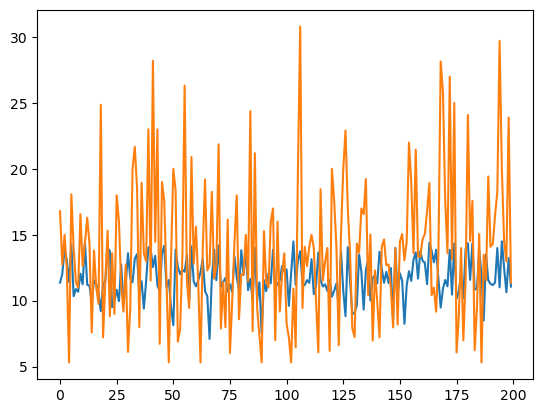

In [363]:
with torch.no_grad():
   seq_model.eval()
   preds = seq_model(X_test_tsor)
   X_test_feat_0 = X_test[2:, 0:1].reshape(-1)
   preds_decoded = sc_y.inverse_transform(preds)
   y_test_tsor_decoded = sc_y.inverse_transform(y_test_tsor)
   for i in range(0, 10):
      print(f'Prediction / Test [{i}] = '
            f'{preds_decoded[i].reshape(-1, 1)} / '
            f'{y_test_tsor_decoded[i].reshape(-1, 1)}')
   plt.cla()
   plt.plot(preds_decoded)
   plt.plot(y_test_tsor_decoded)
   # plt.scatter(X_test_feat_0[0:10], y_test[0:10])
   # plt.scatter(X_test_feat_0[0:10], preds[0:10])
